# COM2004/3004 - Linear Classification

*Copyright &copy; 2023 University of Sheffield. All rights reserved*.

## Objectives

* To gain some practical experience with linear classification.
* To reduce a Bayesian classifier to a linear classifier by constraining the covariances of the classes to be equal.
* To compare the performance of agenerative model and a discriminative model on a challenging classification task.

## 1. Background

In this lab class, we will be comparing ‘generative modelling’ and ‘discriminative modelling’ ap- proaches to linear classification. For the ‘generative’ approach, we will be revisiting the Bayesian classification code that we used in the previous exercises but we will constrain the system to have equal covariance matrices, i.e., one covariance matrix to represent all the classes, rather than each class having its own covariance matrix. Under this condition the system becomes a linear classifier. We will compare this with a ‘discriminative’ approach where we directly learn the linear classifier parameters using the perceptron learning algorithm.

## 2. Introduction

In this notebook we will be using another data set from the UCI machine-learning repository: abalone data. An abalone is a type of sea snail. The age of a specimen can be determined by cutting the shell through the cone and counting rings through a microscope (rather like trees), but this is a time consuming and expensive procedure. The task here is to try and predict the number of rings given simple external measurements of the weight and dimension of the animal.

For the data set that we are using, the true value for the number of rings is known (i.e., the rings were counted after the snails were measured). Results vary from 1 to 29 rings, so this would usually be treated as a 29-class classification problem. To simplify things a little I have regrouped the data into just two classes of roughly equal size: young (less than 10 rings) and old (10 or more rings). I have also only taken the female samples. There are 7 measurements (which are all quite highly correlated) that are to be used to predict the class label. (The precise meaning of the measurements can be found here http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.names)

Compared to the wine classification task, this task is more challenging. It will be impossible to get 100% correct because the classes are not linearly separable. Further, most of the specimens have either 8, 9, 10 or 11 rings and so lie close to the young/old borderline. However, you should be able to get percentage correct scores that are considerably higher than the 50% that would be expected by guessing alone.

## Task 1. Obtaining data

As in previous lab classes, the data can be read directly into an numpy array using the numpy loadtxt function, as in the cell below. The data will form a matrix with 1,307 rows and 8 columns. Each row is a separate sample (i.e., a different snail). The first column stores a class label (1 for ‘young’ or 2 for ‘old’). Columns 1 to 7 are the results of the 7 length and weight measurements.

In [5]:
import numpy as np
X = np.loadtxt(open("data/abalone.txt", "r"))
X.shape

(1307, 8)

## Task 2. Generative modeling: Bayesian classification with equi-covariant multi-variate normal distributions.

Compared to last notebook, there are a lot more samples (1,307 compared with 178) so we will not worry about leave-one-out testing, instead, we will simply cut the data into equal sized testing and training sets like we did in the first half of the last notebook.

By adapting the code you wrote last time, evaluate the performance of a Bayesian classifier using multivariate normal distributions with full covariance matrics. When considering changes to the code, note that the main difference is that in this notebook there are only two classes rather than three. (If you wish you may trying wrapping the code into a function and seeing if you can design it so that it works for any number of classes.)

How well does your classifier perform? The score will probably be in the 60%-70% range for this task, so don’t worry if performance seems a lot poorer than that for the previous task. If the perfomance is less the 60% then you should check your code for possible bugs.

(424, 8)
(212, 8)
(2, 654)
(654,)
[64.52599388]


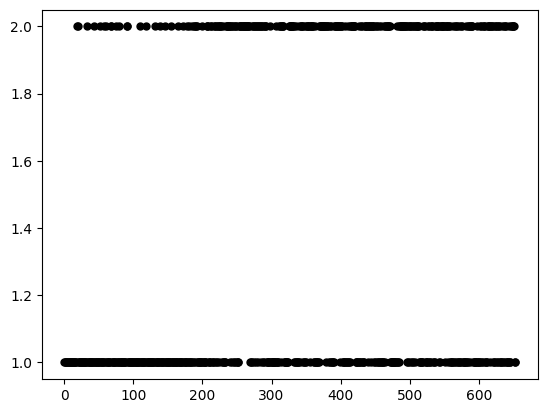

In [6]:
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
%matplotlib inline
abalone1 = X[X[:, 0] == 1]
abalone2 = X[X[:, 0] == 2]
print(abalone1.shape)
abalone1_test = abalone1[0::2, :]
print(abalone1_test.shape)
abalone1_train = abalone1[1::2, :]

abalone2_test = abalone2[0::2, :]
abalone2_train = abalone2[1::2, :]
abalone_test = np.vstack((abalone1_test, abalone2_test))
abalone_test.shape
'''
adapting the code by with full covariance matrics
'''
mean1 = np.mean(abalone1_train[:, 1:], axis=0)
mean2 = np.mean(abalone2_train[:, 1:], axis=0)
cov1 = np.cov(abalone1_train[:, 1:], rowvar=0)
cov2 = np.cov(abalone2_train[:, 1:], rowvar=0)

dist1 = multivariate_normal(mean=mean1, cov=cov1)
dist2 = multivariate_normal(mean=mean2, cov=cov2)
p1 = dist1.pdf(abalone_test[:, 1:])
p2 = dist2.pdf(abalone_test[:, 1:])
p = np.vstack((p1, p2))
print(p.shape)
index = np.argmax(p, axis=0) + 1
print(index.shape)
plt.plot(index, "k.", ms=10)
correct = abalone_test[:, 0] == index
percent_correct = np.sum(correct) * 100.0 / index.shape
print(percent_correct)

**Using equal covariance matrices.**
If you correctly followed the same procedures as last notebook you will have estimated a separate covariance matrix for each class. These matrices will not be equal and so your system will not be a linear classifier (i.e., it will have a non-planar decision boundary). In order to reduce it down to a linear system we need to ensure that there is only one covariance matrix. There are different ways that you might imagine doing this:

First, you might imagine simply estimating a single covariance matrix from the complete training set before dividing it into classes. This produces a single matrix but it is not the correct thing to do. We want the matrix to represent the spread within the classes, if you simply train a model using the full training data set it will also be capturing the spread between the classes.

Second, you could imagine averaging the two class-dependent covariance matrices. This is closer to the correct thing but it doesn’t take care of the fact that the classes might have had unequal numbers of examples.
The best approach is to first move the centres of the two classes onto the same point and then treat them as a single class. To move the class centres onto the same point you can simply subtract the class mean vector from each data sample.

E.g., for each sample in class one you need to compute,

**abalone1_train (i, :)   – mean1**

and for each sample in class two you would compute,

**abalone2_train(i, :)   – mean2**

You can do this without a loop. In fact you can just type

**abalone1_train   – mean1**


When numpy sees a vector being subtracted from a matrix like this, it will automatically copy the vector so that it is subtracted from every row of the matrix (this is called ‘broadcasting’).

Go ahead and modify your code so that a single covariance matrix is computed called, for example, cov_global.

In [7]:
def centre_data(data):
    '''
    complete the code here
    '''
    nsamples = data.shape[0]
    data_mean = np.mean(data, axis=0)
    data_centred = data - data_mean
    return data_centred
abalone1_centred = centre_data(abalone1_train)
abalone2_centred = centre_data(abalone2_train)
abalone_centred = np.vstack((abalone1_centred, abalone2_centred))
cov_global = np.cov(abalone_centred[:, 1:], rowvar=0)

You can now redo the classification using this single matrix in both the mvnpdf evaluations, i.e.,

**p1 = mvnpdf(abalone1_test, mean1, cov_global);**

**p2 = mvnpdf(abalone2_test, mean2, cov_global);**

**etc**

What is the new result? How does it compare with the result when using the more flexible non-linear classifer (i.e., when using two different covariance matrices)?

[67.12538226]


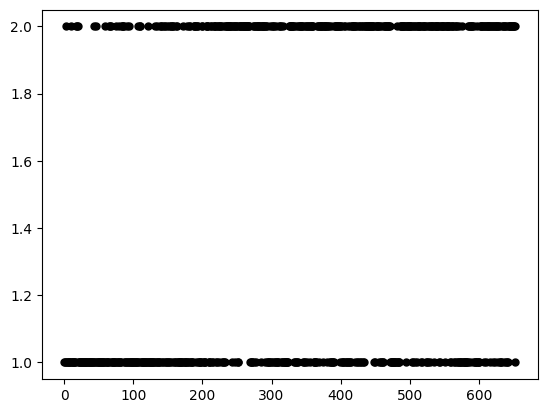

In [8]:
dist1 = multivariate_normal(mean=mean1, cov=cov_global)
dist2 = multivariate_normal(mean=mean2, cov=cov_global)
p1 = dist1.pdf(abalone_test[:, 1:])
p2 = dist2.pdf(abalone_test[:, 1:])
p = np.vstack((p1, p2))
index = np.argmax(p, axis=0) + 1
plt.plot(index, "k.", ms=10)
correct = abalone_test[:, 0] == index
percent_correct = np.sum(correct) * 100.0 / index.shape
print(percent_correct)

If we wished, we could represent this linear Gaussian classifier in the standard linear classifier form, i.e. g(x) = w’x + w0 and output ω1 if g(x) > 0 else ω2. The parameters w’ and w0 would simply be a function of the covariance matrix and the class means that we have learnt from the training data. Actually, although this would involve an extra bit of calculation, once we had computed w’ and w0, all the test points could be classified very quickly by evaluating g(x) directly (e.g., for an N -dimension problem this amounts to just N + 1 multiplications, N additions and a comparison against 0).

## PART 2 – Programming Challenge

## 4.1 8. Programming exercise

**Exercise 1.** Simulate tossing a fair coin 1,000,000 times. Count the length of each sequence of identical outcomes. Plot a histogram of the result.

For example, the following sequence, H H H T T H H H H T T T, would count as 1 sequence of 2 (T T); 2 sequences of 3 (H H H and T T T) and 1 sequence of 4 (H H H H).

Hint: the coin toss can be simulated by using the function ‘rand’ to pick a number between 0 and 1 and outputting heads if the number is greater than 0.5 or else outputting tails. Write your solution using a for-loop to start with.

Can you find a way of ‘vectorising’ your algorithm – i.e. writing it without loops? Is it faster?

Time your solutions using timeit.

1.33 s ± 61.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


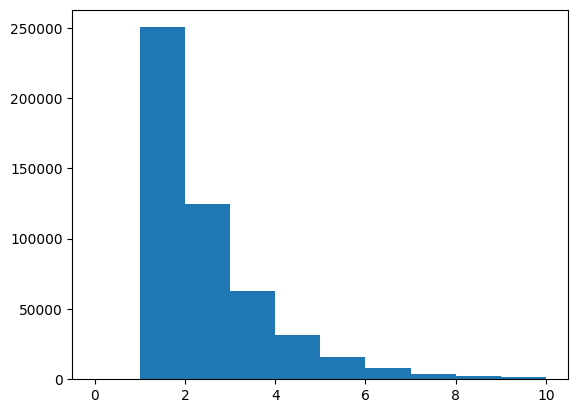

In [9]:
import matplotlib.pyplot as plt

def do_tosses(ntosses):
    '''
    write your solution here
    '''
    outcomes = np.random.rand(ntosses) > 0.5
    sequence_length = 1
    sequence_lengths = []
    last_outcome = outcomes[0]
    for outcome in outcomes[1:]:
        if outcome != last_outcome:
          sequence_lengths.append(sequence_length)
          sequence_length = 1
        else:
          sequence_length += 1
          last_outcome = outcome
    sequence_lengths.append(sequence_length)
    return sequence_lengths

%timeit do_tosses(1000000)

sequence_lengths = do_tosses(1000000)
x = plt.hist(sequence_lengths, bins=np.linspace(0, 10, 11))

[ True False  True ...  True  True False]
(array([      0,       1,       3, ...,  999997,  999998, 1000000]),)
[[1]
 [2]
 [1]
 ...
 [2]
 [1]
 [2]]
[ 0.          0.20408163  0.40816327  0.6122449   0.81632653  1.02040816
  1.2244898   1.42857143  1.63265306  1.83673469  2.04081633  2.24489796
  2.44897959  2.65306122  2.85714286  3.06122449  3.26530612  3.46938776
  3.67346939  3.87755102  4.08163265  4.28571429  4.48979592  4.69387755
  4.89795918  5.10204082  5.30612245  5.51020408  5.71428571  5.91836735
  6.12244898  6.32653061  6.53061224  6.73469388  6.93877551  7.14285714
  7.34693878  7.55102041  7.75510204  7.95918367  8.16326531  8.36734694
  8.57142857  8.7755102   8.97959184  9.18367347  9.3877551   9.59183673
  9.79591837 10.        ]


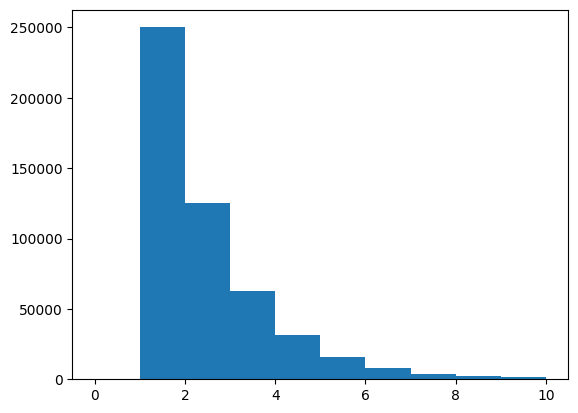

In [10]:
def do_tosses2(ntosses):
    '''
    Using a way of ‘vectorising’ to tackle it
    '''
    outcomes = np.random.rand(ntosses) > 0.5
    changes = outcomes[1:] != outcomes[:-1]
    print(changes)
    changes = np.insert(changes, 0, True)
    changes = np.append(changes, True)
    change_positions = np.where(changes == True)
    print(change_positions)
    sequence_lengths = np.diff(change_positions)
    print(sequence_lengths.T)
    return sequence_lengths.T

#%timeit do_tosses2(1000000)

sequence_lengths = do_tosses2(1000000)
x = plt.hist(sequence_lengths, bins=np.linspace(0, 10,11))
print(np.linspace(0, 10))

**Exercise 2.** Bias the coin so that it comes up heads with a probability, p, greater than 0.5. How does the shape of the histogram vary with increasing p?

[False False False ...  True  True False]
(array([      0,       7,       9, ...,  999997,  999998, 1000000]),)
[[7]
 [2]
 [3]
 ...
 [1]
 [1]
 [2]]


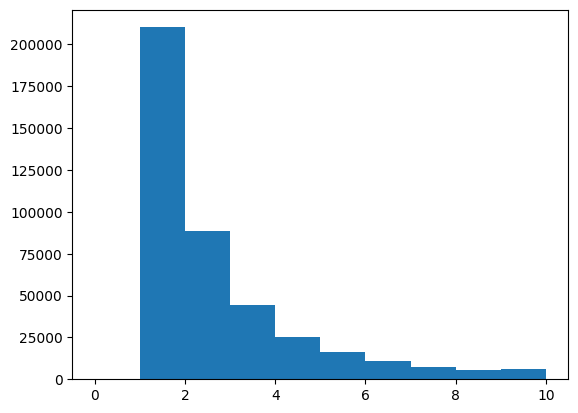

In [11]:
def do_biased_tosses(bias, ntosses):
    '''
    write your solution here
    '''
    outcomes = np.random.rand(ntosses) > bias
    changes = outcomes[1:] != outcomes[:-1]
    print(changes)
    changes = np.insert(changes, 0, True)
    changes = np.append(changes, True)
    change_positions = np.where(changes == True)
    print(change_positions)
    sequence_lengths = np.diff(change_positions)
    print(sequence_lengths.T)
    return sequence_lengths.T

# biased coin produces relatively more long unchanging sequences
sequence_lengths = do_biased_tosses(0.7, 1000000)
x = plt.hist(sequence_lengths, bins=np.linspace(0, 10, 11))